# scGPT-Spatial Single Slide Domain Detection Evaluation (Zero-shot)
This notebook is to evaluate the performance on single-slide domain detection, from the perspectives of prediction accuracy, spatial domain continuity, robustness and visualization.

Input: spatial coordinates, true layer, predicted layer




In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc

# load data
adata = sc.read_h5ad('../../approaches_impl/data/1-visium.h5ad')
adata = adata[np.logical_not(adata.obs['ground_truth'].isna())]  #remove NAN
print(adata)
print(adata.obs.ground_truth.unique())

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import approaches_impl.scGPT_spatial.scgpt_spatial as scgpt_spatial

# run scGPT-spatial zero-shot inference
model_dir = '../../approaches_impl/scGPT_spatial/checkpoints/scGPT_spatial_v1'
gene_col = 'gene_ids'
ref_embed_adata = scgpt_spatial.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    obs_to_save=['array_row', 'array_col', 'ground_truth'],
    batch_size=64,
    return_new_adata=False,
    use_fast_transformer=False
)
print(ref_embed_adata)

D:\Beaver\code\ST_FM_Benchmark\approaches_impl\scGPT_spatial\scgpt_spatial\tasks\cell_emb.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["id_in_vocab"] = [
C:\Users\liuzh\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\liuzh\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
Embedding cells:   0%|          | 0/66 [00:00<?, ?it/s]

In [ ]:
from approaches_impl.scGPT_spatial.st_fm_benchmark.domain_detection import predict_domain_using_embedding

# run leiden for domain detection w. scGPT-spatial embeddings
adata = predict_domain_using_embedding(adata, dom_key='domain', method='leiden', rep_key='X_scGPT', target_clusters=6,
                                       n_neighbors=15)
print(adata)

In [ ]:
mapping = {1: 'Layer1', 2: 'Layer2', 3: 'Layer3', 4: 'Layer4', 5: 'Layer5', 6: 'Layer6'}
adata.obs['domain'] = adata.obs["domain"].map(mapping).fillna(0)

## 1. Prediction Accuracy

In [5]:
from evaluation import STFMEvaluation

eval = STFMEvaluation()
metrics = eval.compute_prediction_accuracy(df.ground_truth, df.domain)

metrics.to_csv('../approaches/BASS/data/1_visium/1_visium_bass_accuracy_metrics.csv', sep=',')
print(metrics)

ARI          0.515112
NMI          0.657387
HOM          0.628779
COM          0.688723
V_Measure    0.657387
dtype: float64


## 2. Spatial Domain Continuity

In [6]:
domain_continuity_metrics = eval.compute_domain_continuity(spatial_coordinates=pd.concat([df.x, df.y], axis=1),
                                                           labels_pred=df.domain)
domain_continuity_metrics.to_csv('../approaches/BASS/data/1_visium/1_visium_bass_continuity_metrics.csv', sep=',')
print(domain_continuity_metrics)

ASW      0.034687
CHAOS    0.058493
PAS      0.031983
dtype: float64


## 3. Visualization


In [3]:
from evaluation import merge_df_into_adata_obs

# merge output into adata
joined_adata = merge_df_into_adata_obs(adata, bass_output, cell_col='cell', how='left',
                                       suffix='_bass', copy=True, allow_duplicates=False)
print(joined_adata)

AnnData object with n_obs × n_vars = 4221 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region', 'ground_truth', 'slice_bass', 'x_bass', 'y_bass', 'domain_bass'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


#### a. Histology

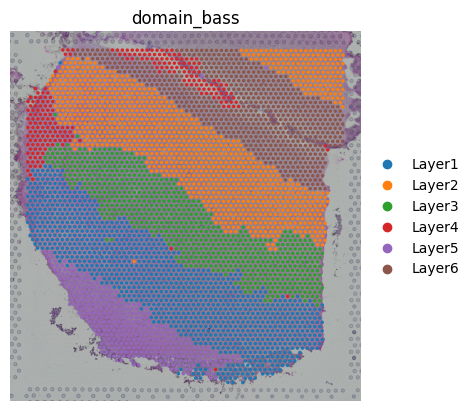

In [4]:
from evaluation import STFMEvaluation

# prediction
eval = STFMEvaluation()
eval.plot_spatial_domains(joined_adata, domain_col='domain_bass', use_histology=True, slice_id='151507',
                          save='../approaches/BASS/data/1_visium/pred_spatial_domains.png')

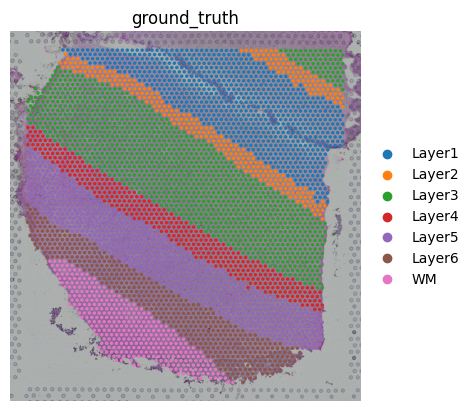

In [5]:
# ground truth
eval.plot_spatial_domains(joined_adata, domain_col='ground_truth', use_histology=True, slice_id='151507',
                          save='../approaches/BASS/data/1_visium/ground_truth_spatial_domains.png')

#### b. UMAP

/Users/sheryli/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


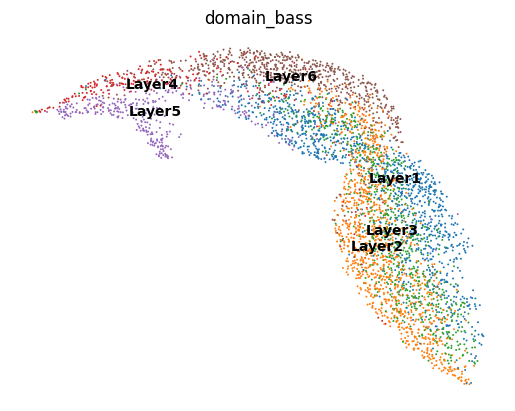

In [6]:
# prediction
eval.plot_embedding_domains(joined_adata, domain_col='domain_bass', basis='umap', compute_if_missing=True,
                            save='../approaches/BASS/data/1_visium/pred_emb_domains.png')

/Users/sheryli/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


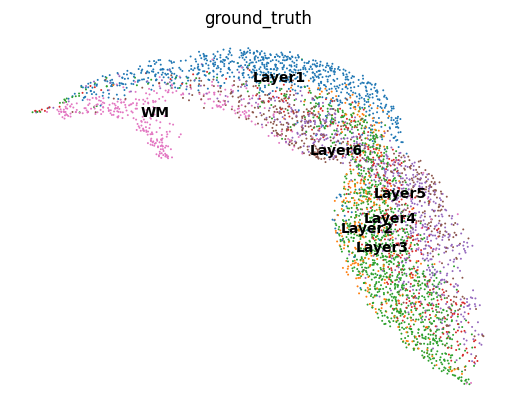

In [7]:
# ground truth
eval.plot_embedding_domains(joined_adata, domain_col='ground_truth', basis='umap', compute_if_missing=True,
                            save='../approaches/BASS/data/1_visium/ground_truth_emb_domains.png')

## [TODO] 4. Robustness